In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from string import punctuation

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
def trim(dataset):
  # using .strip() to remove the leading and the trailing white spaces in each cell
  trim = lambda x: x.strip() if type(x) is str else x
  return dataset.applymap(trim)

# 1. Bus

In [90]:
df_bus = pd.read_excel('../data/raw_data/ttc-bus-delay-data-2023.xlsx')
df_bus.head()

,Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2023-01-01,91,02:30,Sunday,WOODBINE AND MORTIMER,Diversion,81,111,NaN,8772
1,2023-01-01,69,02:34,Sunday,WARDEN STATION,Security,22,44,S,8407
2,2023-01-01,35,03:06,Sunday,JANE STATION,Cleaning - Unsanitary,30,60,N,1051
3,2023-01-01,900,03:14,Sunday,KIPLING STATION,Security,17,17,NaN,3334
4,2023-01-01,85,03:43,Sunday,MEADOWALE LOOP,Security,1,1,NaN,1559


## 1.1 Overview

In [91]:
df_bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56207 entries, 0 to 56206
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       56207 non-null  datetime64[ns]
 1   Route      55637 non-null  object        
 2   Time       56207 non-null  object        
 3   Day        56207 non-null  object        
 4   Location   56207 non-null  object        
 5   Incident   56207 non-null  object        
 6   Min Delay  56207 non-null  int64         
 7   Min Gap    56207 non-null  int64         
 8   Direction  46667 non-null  object        
 9   Vehicle    56207 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 4.3+ MB


In [92]:
[print(i,df_bus[i].value_counts().shape) for i in df_bus.columns]

Date (365,)
Route (264,)
Time (1440,)
Day (7,)
Location (11684,)
Incident (13,)
Min Delay (500,)
Min Gap (538,)
Direction (16,)
Vehicle (2392,)


[None, None, None, None, None, None, None, None, None, None]

In [93]:
bus_df = df_bus.copy()

In [94]:
bus_df.columns = [i.replace(' ', '_').lower() for i in bus_df.columns]

In [95]:
bus_df.isna().sum()

date            0
route         570
time            0
day             0
location        0
incident        0
min_delay       0
min_gap         0
direction    9540
vehicle         0
dtype: int64

In [96]:
# bus_df['direction'].fillna('unknown', inplace = True)
# bus_df.dropna(subset=['route'], inplace=True)

## 1.2 Route

In [97]:
bus_df['route'].unique()

array([91, 69, 35, 900, 85, 40, 336, 52, 24, 36, 300, 320, 960, 307, 96,
       73, 102, 90, 112, 72, 34, 106, 84, 81, 63, 25, 57, 86, 124, 38, 59,
       43, 51, 87, 104, 47, 32, 71, 165, 108, 68, 89, 929, 53, 95, 504,
       13, 60, 94, 11, 7, 927, 39, 65, 935, 116, 161, 17, 14, 98, 335, 45,
       131, 31, 80, 118, nan, 33, 120, 169, 61, 985, 100, 939, 79, 83, 29,
       56, 168, 109, 353, 30, 12, 105, 134, 121, 110, 15, 76, 107, 41,
       129, 54, 44, 123, 75, 10, 160, 133, 67, 126, 50, 70, 905, 167, 925,
       984, 600, 46, 42, 310, 954, 945, 995, 127, 62, 941, 135, 122, 26,
       996, 19, 113, 9, 176, 111, 21, 924, 989, 952, 119, 130, 22, 37,
       902, 986, 953, 944, 97, 92, 501, 74, 16, 101, 66, 77, 937, 20, 385,
       999, 943, 396, 363, 82, 312, 324, 55, 125, 99, 23, 132, 48, 28,
       343, 329, 334, 64, 88, 171, 78, 339, 301, 968, 'RAD 600', 325,
       'RAD', 49, 162, 395, 93, 337, 322, 332, 8, 365, 115, 341, 468, 315,
       938, 'SHUTTLE', 354, 'A236', 189, 510, 352

In [98]:
bus_df.dropna(subset=['route'], inplace=True)

In [99]:

bus_df['route'] = pd.to_numeric(bus_df['route'], errors='coerce')
bus_df.dropna(subset=['route'], inplace=True)
bus_df['route'] = bus_df['route'].astype('int')

In [100]:
bus_df = bus_df[~((bus_df['route'] >= 600) & (bus_df['route'] <900))]
bus_df = bus_df.loc[(bus_df['route'] >= 5) & (bus_df['route'] <= 999)]

## 1.3 Direction

In [101]:
bus_df['direction'].value_counts()

direction
N    12809
S    12081
E    11018
W    10125
B       58
`        2
D        1
1        1
\        1
L        1
G        1
H        1
7        1
/        1
0        1
M        1
Name: count, dtype: int64

In [102]:
bus_df['direction'] = bus_df['direction'].replace(['B', '`', 'H','0', '/', '7', '1', 'G','L',"\\",'D','M'], 'unknown')
bus_df['direction'] = bus_df['direction'].fillna('unknown')

In [103]:
bus_df['direction'].value_counts()

direction
N          12809
S          12081
E          11018
W          10125
unknown     8952
Name: count, dtype: int64

## 1.4 Location

In [104]:
len(bus_df["location"].value_counts())

11361

In [105]:
# chuẩn hóa một số dấu phân cách
bus_df['location'] = [i.replace('(', '').lower() for i in bus_df['location']]
bus_df['location'] = [i.replace(')', '') for i in bus_df['location']]
bus_df['location'] = [i.replace(' ', '_') for i in bus_df['location']]
bus_df['location'] = [i.replace('  ', '_') for i in bus_df['location']]
bus_df['location'] = [i.replace('.', '_') for i in bus_df['location']]
bus_df['location'] = [i.replace("'", '_') for i in bus_df['location']]
bus_df['location'] = [i.replace('__', '_') for i in bus_df['location']]
bus_df['location'] = [i.replace('___', '_') for i in bus_df['location']]
bus_df['location'] = [i.replace('_-_', '_') for i in bus_df['location']]
bus_df['location'] = [i.replace('-', '_') for i in bus_df['location']]
bus_df['location'] = [i.replace('--', '_') for i in bus_df['location']]

bus_df['location'] = [i.replace('_nd_', '/') for i in bus_df['location']]
bus_df['location'] = [i.replace('_/_', '/') for i in bus_df['location']]
bus_df['location'] = [i.replace('_&_', '/') for i in bus_df['location']]
bus_df['location'] = [i.replace('_at_', '/') for i in bus_df['location']]
bus_df['location'] = [i.replace('_on_', '/') for i in bus_df['location']]
bus_df['location'] = [i.replace('/on_', '/') for i in bus_df['location']]

In [106]:
#Thay đổi một số từ viết tắt phổ biến
bus_df['location'] = [i.replace('stn', 'station') for i in bus_df['location']]
bus_df['location'] = [i.replace('stations', 'station') for i in bus_df['location']]
bus_df['location'] = [i.replace('stationq', 'station') for i in bus_df['location']]
bus_df['location'] = [i.replace('ave_', 'avenue_') for i in bus_df['location']]
bus_df['location'] = [i.replace('_ave', '_avenue') for i in bus_df['location']]
bus_df['location'] = [i.replace('street', 'st') for i in bus_df['location']]

In [107]:
def checkexpression(expression):
    '''
    Takes a string and searches for similar entries in the locations dataframe created inside the functio.
    expression must be put inside ''. e.g checkexpression('expression')
    '''
    assert isinstance(expression, str), "Please add '' to your expresssion"
    locations = pd.DataFrame(bus_df['location'].value_counts())
    #locations.reset_index(inplace = True)
    locations = locations.rename(columns={"index": "location", "location": "counts"})
    loop_list = locations.filter(like= expression , axis=0)
    return loop_list.head(30)

In [108]:
bus_df['location'] = bus_df['location'].replace(['stc_station', 'scarborough_town_centre','scarborough_town_centr', 'scarborough_centre_sta', 'scarborough_center_sta',
                                                 'u_of_t_scarb_college_l', 'scarborough_town_stati', 'scarborough_town_cent', 'scarborough_cenntenary', 
                                                 'scarbrough_town_centre', 'scarbrough_town_centre', 'scarborough_towne_cent', 'scarborough_towne_cent', 
                                                 'scarborough_town_cente', 'scarborough_centre_cen', 'scarborough_ctr_station', 'scarborough_centre_st',
                                                 'scarborough_centre', 'scarborough_town', 'scarborough_centre_bus', 'u_of_t_scarborough', 'u_of_t_scarborough_bus',
                                                 'u_of_t_scarborough_c', 'u_of_t_scarborough_col', 'u_of_t_scarborough_loo', 'scarborough_u_of_t_loo'], 'scarborough_town_center_station')

bus_df['location'] = bus_df['location'].replace(['kenendy_station'], 'kennedy_station')
bus_df['location'] = bus_df['location'].replace(['yorkmills_station', 'york_mill_station'], 'york_mills_station')


In [109]:
bus_df['location'] = [i.replace('_', ' ') for i in bus_df['location']]
bus_df['location'] = [i.replace('/', ' ') for i in bus_df['location']]
bus_df['location'] = [i.replace('   ', ' ') for i in bus_df['location']]
bus_df['location'] = [i.replace('  ', ' ') for i in bus_df['location']]

In [110]:
bus_df['location'] = bus_df['location'].str.lower().str.replace(rf'[{punctuation}]', '')

## 1.5 incident

In [111]:
bus_df["incident"].value_counts()

incident
Mechanical                          19001
Operations - Operator               11165
Security                             4652
Diversion                            3777
Collision - TTC                      3653
General Delay                        3154
Emergency Services                   2910
Utilized Off Route                   2266
Cleaning - Unsanitary                2138
Investigation                        1173
Vision                                777
Road Blocked - NON-TTC Collision      244
Held By                                75
Name: count, dtype: int64

<Axes: xlabel='incident', ylabel='count'>

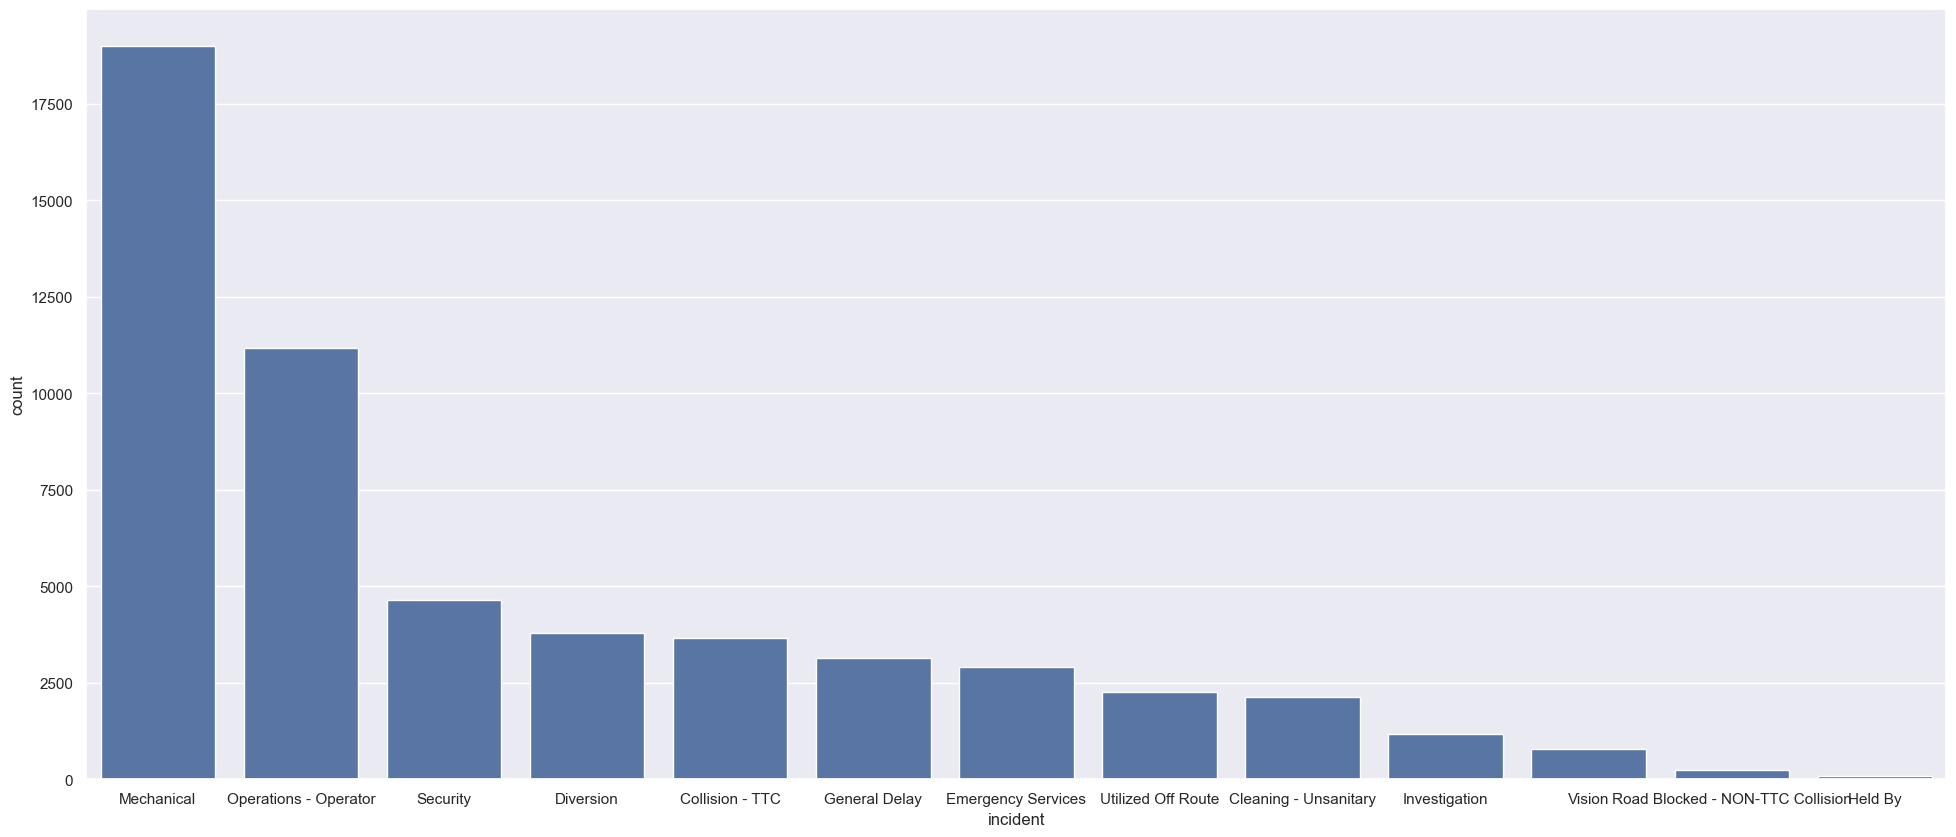

In [112]:
plt.rcParams["figure.figsize"] = (24,10)
Incident = bus_df['incident'].value_counts()
sns.barplot(x=Incident.index, y=Incident)

## 1.6 min_delay


(0.0, 150.0)

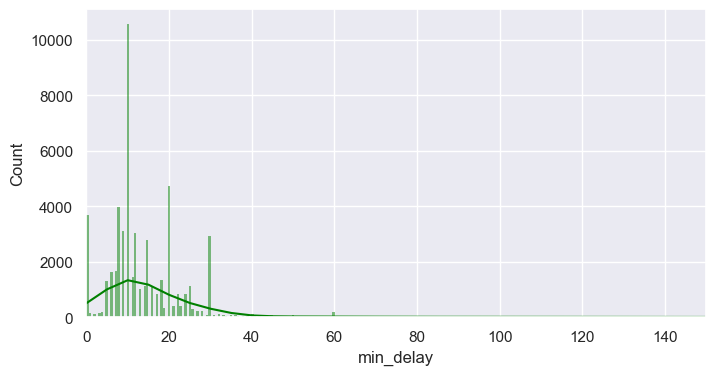

In [113]:
sns.set(rc={'figure.figsize':(8,4)})
sns.histplot(data = bus_df['min_delay'], kde=True , color='green')
plt.xlim([0,150])

In [114]:
# xem trễ trên 60p là ngoại lệ
bus_df.drop(bus_df[bus_df["min_delay"] > 90].index, inplace=True)
bus_df['min_delay'] = bus_df['min_delay'].astype('int')

In [115]:
# remove delay = 0
bus_df = bus_df[bus_df['min_delay']>1]

## 1.7 min_gap

(0.0, 150.0)

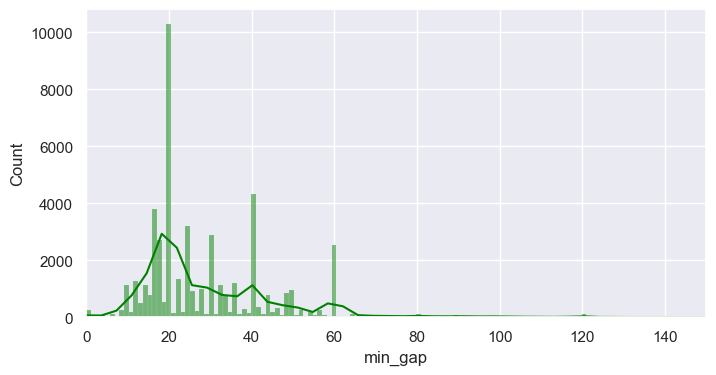

In [116]:
sns.set(rc={'figure.figsize':(8,4)})
sns.histplot(data = bus_df['min_gap'], kde=True , color='green')
plt.xlim([0,150])

In [117]:
# xem trên 90p là ngoại lệ
bus_df.drop(bus_df[bus_df["min_gap"] > 90].index, inplace=True)
bus_df['min_gap'] = bus_df['min_gap'].astype('int')

## 1.8 Date and Time

In [118]:
bus_df['day_month'] = bus_df['date'].dt.day
bus_df['month'] = bus_df['date'].dt.month
# df['year'] = df['date'].dt.year

In [119]:
bus_df['time'] = pd.to_datetime(bus_df['time']).dt.time

C:\Users\admin\AppData\Local\Temp\ipykernel_27540\3820836541.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bus_df['time'] = pd.to_datetime(bus_df['time']).dt.time


In [120]:
# df['Time'] = pd.to_datetime(df['Time']).dt.time
bus_df['hour'] = bus_df['time'].map(lambda x: x.hour)
bus_df['min'] = bus_df['time'].map(lambda x: x.minute)

In [121]:
bus_df.head()

,date,route,time,day,location,incident,min_delay,min_gap,direction,vehicle,day_month,month,hour,min
1,2023-01-01,69,02:34:00,Sunday,warden station,Security,22,44,S,8407,1,1,2,34
2,2023-01-01,35,03:06:00,Sunday,jane station,Cleaning - Unsanitary,30,60,N,1051,1,1,3,6
3,2023-01-01,900,03:14:00,Sunday,kipling station,Security,17,17,unknown,3334,1,1,3,14
7,2023-01-01,52,04:25:00,Sunday,lawrence and yonge,Emergency Services,30,60,E,3520,1,1,4,25
8,2023-01-01,24,04:35:00,Sunday,danforth and main,Cleaning - Unsanitary,20,40,W,8404,1,1,4,35


## 1.9 Save

In [122]:
# dòng trùng
bus_df.duplicated().sum()
bus_df = bus_df.drop_duplicates()

In [123]:
bus_df = trim(bus_df)

C:\Users\admin\AppData\Local\Temp\ipykernel_27540\2044505389.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return dataset.applymap(trim)


In [124]:
bus_df.head()

,date,route,time,day,location,incident,min_delay,min_gap,direction,vehicle,day_month,month,hour,min
1,2023-01-01,69,02:34:00,Sunday,warden station,Security,22,44,S,8407,1,1,2,34
2,2023-01-01,35,03:06:00,Sunday,jane station,Cleaning - Unsanitary,30,60,N,1051,1,1,3,6
3,2023-01-01,900,03:14:00,Sunday,kipling station,Security,17,17,unknown,3334,1,1,3,14
7,2023-01-01,52,04:25:00,Sunday,lawrence and yonge,Emergency Services,30,60,E,3520,1,1,4,25
8,2023-01-01,24,04:35:00,Sunday,danforth and main,Cleaning - Unsanitary,20,40,W,8404,1,1,4,35


In [125]:
bus_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49051 entries, 1 to 56206
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       49051 non-null  datetime64[ns]
 1   route      49051 non-null  int64         
 2   time       49051 non-null  object        
 3   day        49051 non-null  object        
 4   location   49051 non-null  object        
 5   incident   49051 non-null  object        
 6   min_delay  49051 non-null  int64         
 7   min_gap    49051 non-null  int64         
 8   direction  49051 non-null  object        
 9   vehicle    49051 non-null  int64         
 10  day_month  49051 non-null  int64         
 11  month      49051 non-null  int64         
 12  hour       49051 non-null  int64         
 13  min        49051 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(5)
memory usage: 5.6+ MB


In [126]:
[print(i,bus_df[i].value_counts().shape) for i in bus_df.columns]

date (365,)
route (214,)
time (1440,)
day (7,)
location (10107,)
incident (13,)
min_delay (84,)
min_gap (91,)
direction (5,)
vehicle (2327,)
day_month (31,)
month (12,)
hour (24,)
min (60,)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [127]:
bus_df.to_csv('../data/clean_data/bus_clean.csv', index=False)

# 2. Subway

In [4]:
df_subway = pd.read_excel('../data/raw_data/ttc-subway-delay-data-2023.xlsx')
df_subway.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2023-01-01,02:22,Sunday,MUSEUM STATION,MUPAA,3,9,S,YU,5931
1,2023-01-01,02:30,Sunday,KIPLING STATION,MUIS,0,0,E,BD,5341
2,2023-01-01,02:33,Sunday,WARDEN STATION,SUO,0,0,W,BD,0
3,2023-01-01,03:17,Sunday,KEELE STATION,MUIS,0,0,NaN,BD,0
4,2023-01-01,07:16,Sunday,BATHURST STATION,MUIS,0,0,NaN,BD,0


## 2.1 Overview

In [5]:
df_subway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20882 entries, 0 to 20881
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       20882 non-null  datetime64[ns]
 1   Time       20882 non-null  object        
 2   Day        20882 non-null  object        
 3   Station    20882 non-null  object        
 4   Code       20882 non-null  object        
 5   Min Delay  20882 non-null  int64         
 6   Min Gap    20882 non-null  int64         
 7   Bound      13157 non-null  object        
 8   Line       20834 non-null  object        
 9   Vehicle    20882 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 1.6+ MB


In [6]:
[print(i,df_subway[i].value_counts().shape) for i in df_subway.columns]

Date (334,)
Time (1409,)
Day (7,)
Station (359,)
Code (176,)
Min Delay (108,)
Min Gap (113,)
Bound (5,)
Line (13,)
Vehicle (697,)


[None, None, None, None, None, None, None, None, None, None]

In [7]:
df = df_subway.copy()

In [8]:
df.columns = [i.replace(' ', '_').lower() for i in df.columns]

In [9]:
df.isna().sum() 

date            0
time            0
day             0
station         0
code            0
min_delay       0
min_gap         0
bound        7725
line           48
vehicle         0
dtype: int64

## 2.2 Date

In [10]:
df['day_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month
# df['year'] = df['date'].dt.year

In [11]:
df.head()

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle,day_month,month
0,2023-01-01,02:22,Sunday,MUSEUM STATION,MUPAA,3,9,S,YU,5931,1,1
1,2023-01-01,02:30,Sunday,KIPLING STATION,MUIS,0,0,E,BD,5341,1,1
2,2023-01-01,02:33,Sunday,WARDEN STATION,SUO,0,0,W,BD,0,1,1
3,2023-01-01,03:17,Sunday,KEELE STATION,MUIS,0,0,NaN,BD,0,1,1
4,2023-01-01,07:16,Sunday,BATHURST STATION,MUIS,0,0,NaN,BD,0,1,1


## 2.3 Time

In [12]:
df['time'] = pd.to_datetime(df['time']).dt.time

C:\Users\admin\AppData\Local\Temp\ipykernel_23876\2743972928.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time']).dt.time


In [13]:
df['hour'] = df['time'].map(lambda x: x.hour)
df['min'] = df['time'].map(lambda x: x.minute)

In [14]:
df.head()

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle,day_month,month,hour,min
0,2023-01-01,02:22:00,Sunday,MUSEUM STATION,MUPAA,3,9,S,YU,5931,1,1,2,22
1,2023-01-01,02:30:00,Sunday,KIPLING STATION,MUIS,0,0,E,BD,5341,1,1,2,30
2,2023-01-01,02:33:00,Sunday,WARDEN STATION,SUO,0,0,W,BD,0,1,1,2,33
3,2023-01-01,03:17:00,Sunday,KEELE STATION,MUIS,0,0,NaN,BD,0,1,1,3,17
4,2023-01-01,07:16:00,Sunday,BATHURST STATION,MUIS,0,0,NaN,BD,0,1,1,7,16


## 2.4 Station

In [15]:
def clean_station_col(text):
    text = re.sub(rf'[{punctuation}]', '',text) # Remove punctuation
    text = re.sub('\s+(BD|SRT|YUS|YU)+\s',' ',text) # Remove BD, SRT,YU,YUS
    text = re.sub('CTR','CENTRE',text) # Replace ctr with centre
    text = re.sub('(SATATIO|STAITON|STATI|CAR HOUSE|STN|STATIO|YARD|WYE|HOSTLER|CARHOUSE|SHOP|SHOPS|LOWER|COMMERCE|HOSTLE)+$',' STATION',text) # Replace texts not end with station to station
    # split by (, TO, AND and only the words before them
    text = text.split('(')[0]
    text = text.split(' TO ')[0]
    text = text.split(' AND ')[0]
    if 'YONGEUNIVERSITY' in text or 'YONGE UNIVERSITY' in text:
        text = 'YONGE UNIVERSITY LINE'
    if  not text.endswith('LINE') and not text.endswith('SUBWAY') and 'STATION' not in text:
        text = text + ' STATION'
    if 'SCARB' in text:
        text = 'SCARBOROUGH CENTRE STATION'
    if 'DAVISVILLE' in text:
        text = 'DAVISVILLE STATION'
    if 'GREENWOOD' in text:
        text = 'GREENWOOD STATION'
    if 'KEELE' in text:
        text = 'KEELE STATION'
    if 'MCCOWAN' in text:
        text = 'MCCOWAN STATION'
    if 'WILSON' in text:
        text = 'WILSON STATION'
    return text

In [16]:
df['station'] = df['station'].apply(clean_station_col)

In [17]:
# a list of station
station_list = ['BATHURST',
'BAY',
'BAYVIEW',
'BESSARION',
'BLOOR',
'BROADVIEW',
'CASTLE FRANK',
'CHESTER',
'CHRISTIE',
'COLLEGE',
'COXWELL',
'DAVISVILLE',
'DON MILLS',
'DONLANDS',
'DOWNSVIEW PARK',
'DUFFERIN',
'DUNDAS',
'DUNDAS WEST',
'DUPONT',
'EGLINTON',
'EGLINTON WEST',
'ELLESMERE',
'FINCH',
'FINCH WEST',
'GLENCAIRN',
'GREENWOOD',
'HIGH PARK',
'HIGHWAY 407',
'ISLINGTON',
'JANE',
'KEELE',
'KENNEDY',
'KING',
'KIPLING',
'LANSDOWNE',
'LAWRENCE',
'LAWRENCE EAST',
'LAWRENCE WEST',
'LESLIE',
'MAIN STREET',
'MCCOWAN',
'MIDLAND',
'MUSEUM',
'NORTH YORK CENTRE',
'OLD MILL',
'OSGOODE',
'OSSINGTON',
'PAPE',
'PIONEER VILLAGE',
'QUEEN',
"QUEEN'S PARK",
'ROSEDALE',
'ROYAL YORK',
'RUNNYMEDE',
'SCARBOROUGH CENTRE',
'SHEPPARD WEST',
'SHEPPARD',
'SHERBOURNE',
'SPADINA',
'ST CLAIR',
'ST CLAIR WEST',
'ST ANDREW',
'ST GEORGE',
'ST PATRICK',
'SUMMERHILL',
'UNION',
'VAUGHAN METRO CENTRE',
'VAUGHAN MC',
'VICTORIA PARK',
'WARDEN',
'WELLESLEY',
'WILSON',
'WOODBINE',
'YORK MILLS',
'YORK UNIVERSITY',
'YORKDALE',
'YONGE',
'QUEENS PARK',
'SCAR',
'SHP',
'NORTH YORK CTR'
]

# create regex pattern out of the list of words
station_list_comb = '|'.join(station_list)
# remove rows from the subway dataset if they don't contain any stations from the station list
df = df[df['station'].str.contains(station_list_comb)]

In [18]:
# remove noisy station names where they have less than 10 delays
df = df[df.groupby(['station'])['date'].transform('count') > 10]

In [19]:
# clean up station column for specific
df['station'] = df['station'].replace(dict.fromkeys(['BLOOR STATION','YONGE STATION'],'BLOOR YONGE STATION'))
df['station'] = df['station'].replace(dict.fromkeys(['SHEPPARDYONGE STATION','SHEPPARD STATION','SHEPPARD-YONGE STATION','YONGE SHEP STATION','YONGE SHP STATION'],'SHEPPARD YONGE STATION'),regex=True)

In [20]:
df['station'] = [i.lower() for i in df['station']]

In [21]:
# if a subway train is delayed at a station
df['at_station'] = df['station'].apply(lambda x: 1 if 'station' in x else 0)

## 2.5 Bound

In [22]:
df['bound'].value_counts()

bound
S    3577
N    3536
W    3037
E    2903
B      39
Name: count, dtype: int64

In [23]:
df['bound'] = df['bound'].replace('B', 'unknown')

In [24]:
df['bound'].fillna('unknown', inplace = True)

C:\Users\admin\AppData\Local\Temp\ipykernel_23876\1425439513.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bound'].fillna('unknown', inplace = True)


## 2.6 Line

In [25]:
df['line'].value_counts()

line
YU           10375
BD            8625
SRT            692
SHP            633
YU/BD          299
YU / BD          6
YUS/BD           6
BD LINE 2        2
BD/YU            1
999              1
YUS              1
YU & BD          1
Name: count, dtype: int64

In [26]:
df['line'] = df['line'].replace(['YU / BD', 'YUS/BD', 'BD/YU', 'YU & BD'], 'YU/BD')
df['line'] = df['line'].replace('YUS', 'YU')
df['line'] = df['line'].replace('999', np.nan)
df['line'] = df['line'].replace('BD LINE 2', 'BD')

In [27]:
df.dropna(subset=['line'], inplace=True)

In [28]:
df['line'].value_counts()

line
YU       10376
BD        8627
SRT        692
SHP        633
YU/BD      313
Name: count, dtype: int64

## 2.7 Min Delay

(0.0, 100.0)

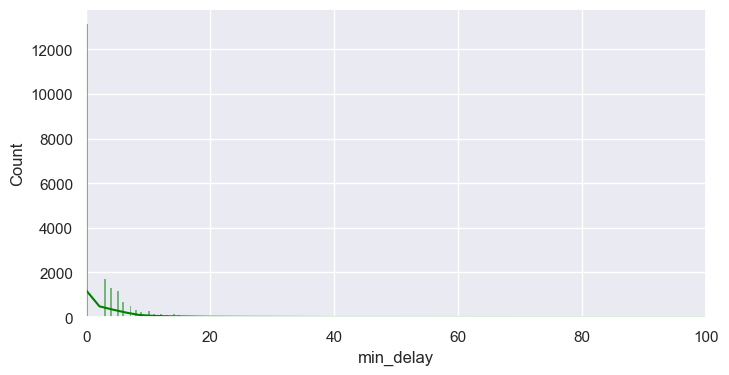

In [29]:
sns.set(rc={'figure.figsize':(8,4)})
sns.histplot(data = df['min_delay'], kde=True , color='green')
plt.xlim([0,100])

In [30]:
# Delays over 40 minutes are considered exceptional
df.drop(df[df["min_delay"] > 40].index, inplace=True)
df['min_delay'] = df['min_delay'].astype('int')

In [31]:
# remove delay = 0
df = df[df['min_delay']>=1]

## 2.8 Save

In [32]:
df.duplicated().sum()
df = df.drop_duplicates()

In [33]:
subway_df = trim(df)

C:\Users\admin\AppData\Local\Temp\ipykernel_23876\2044505389.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return dataset.applymap(trim)


In [34]:
df.head()

,date,time,day,station,code,min_delay,min_gap,bound,line,vehicle,day_month,month,hour,min,at_station
0,2023-01-01,02:22:00,Sunday,museum station,MUPAA,3,9,S,YU,5931,1,1,2,22,1
7,2023-01-01,08:02:00,Sunday,vaughan mc station,TUNOA,6,12,S,YU,5451,1,1,8,2,1
8,2023-01-01,08:11:00,Sunday,greenwood station,MUNOA,5,10,E,BD,0,1,1,8,11,1
10,2023-01-01,08:15:00,Sunday,keele station,TUNOA,5,10,W,BD,0,1,1,8,15,1
11,2023-01-01,08:16:00,Sunday,greenwood station,TUNOA,5,10,E,BD,0,1,1,8,16,1


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7382 entries, 0 to 20880
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        7382 non-null   datetime64[ns]
 1   time        7382 non-null   object        
 2   day         7382 non-null   object        
 3   station     7382 non-null   object        
 4   code        7382 non-null   object        
 5   min_delay   7382 non-null   int32         
 6   min_gap     7382 non-null   int64         
 7   bound       7382 non-null   object        
 8   line        7382 non-null   object        
 9   vehicle     7382 non-null   int64         
 10  day_month   7382 non-null   int32         
 11  month       7382 non-null   int32         
 12  hour        7382 non-null   int64         
 13  min         7382 non-null   int64         
 14  at_station  7382 non-null   int64         
dtypes: datetime64[ns](1), int32(3), int64(5), object(6)
memory usage: 836.2+ KB


In [36]:
[print(i,df[i].value_counts().shape) for i in df.columns]

date (334,)
time (1247,)
day (7,)
station (77,)
code (157,)
min_delay (39,)
min_gap (45,)
bound (5,)
line (4,)
vehicle (615,)
day_month (31,)
month (11,)
hour (24,)
min (60,)
at_station (2,)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [38]:
subway_df.to_csv('../data/clean_data/subway_cleaned_win.csv',index = False)